In this assignment will be using CIFR10 Dataset.

---


*   The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.

*   The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.




In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model,Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Input, Concatenate
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
img_height, img_width, channel = train_features.shape[1],train_features.shape[2],train_features.shape[3]
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

**Sample images from CIFAR-10 dataset**

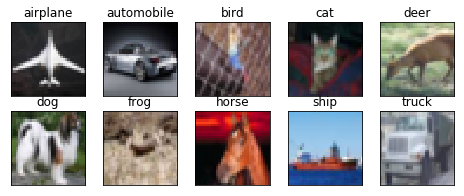

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Utility functions which will help in plotting training and test auuracy vs epochs**

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
import tensorflow as tf
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)
  
def space_to_depth_x4(x):
    return tf.space_to_depth(x, block_size=4)  

From the above base network,  will make few basic changes to improve training accuracy in less number of parameters.

In assignment 6A, following improvements are done.

*   Remove Dense layers
*   Use 1x1 change channel size.
*   Use Batch normalization
*   Add dropouts in right location.
*   Also use Relu after Batch norm.

In this assignment we will add below changes.

*  Normal Convolution
*  Separable Convolution 
*  Depthwise Convolution
*  Grouped Convolution (use 3x3, 5x5 only)
*  Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 



In [14]:
from keras import layers
input_layer = Input(shape=(img_height, img_width, channel,))
num_classes = 10

# Layer 1 - normal convolution
Layer1 = Convolution2D(32, (3,3), strides=(1,1), border_mode='same', name='conv_1', use_bias=False)(input_layer)
Layer1_normalized = BatchNormalization(name='norm_1')(Layer1)
Layer1_normalized_activated = Activation('relu')(Layer1_normalized)

# Layer 2 - normal convolution
Layer2 = Convolution2D(64, (3,3), strides=(1,1), border_mode='same', name='conv_2', use_bias=False)(Layer1_normalized_activated)
Layer2_normalized = BatchNormalization(name='norm_2')(Layer2)
Layer2_normalized_activated = Activation('relu')(Layer2_normalized)

# Layer 3 - sptially seperable convolution i.e  (3,1) followed by (1,3) convolutions, this will result in less number of parameters.
Layer31 = Convolution2D(128, (3,1), strides=(1,1), border_mode='same', name='conv_31', use_bias=False)(Layer2_normalized_activated)
Layer32 = Convolution2D(128, (1,3), strides=(1,1), border_mode='same', name='conv_32', use_bias=False)(Layer31)
Layer3_normalized = BatchNormalization(name='norm_3')(Layer32)
Layer3_normalized_activated = Activation('relu')(Layer3_normalized)

Layer_concatenated_1_2_3 = concatenate([Layer1_normalized_activated, Layer2_normalized_activated, Layer3_normalized_activated])

Layer_concatenated_1_2_3 = Dropout(0.25)(Layer_concatenated_1_2_3)

Layer_trans11 = Convolution2D(32, 1, 1, activation='relu')(Layer_concatenated_1_2_3)
Layer_trans12 = MaxPooling2D(pool_size=(2, 2))(Layer_trans11) #16


# Layer 4 - Depthwise seperable convolution
Layer4 = SeparableConv2D(64, (3,3), strides=(1,1), border_mode='same', name='conv_4', use_bias=False)(Layer_trans12)
Layer4_normalized = BatchNormalization(name='norm_4')(Layer4)
Layer4_normalized_activated = Activation('relu')(Layer4_normalized)

Layer41 = SeparableConv2D(128, (3,3), strides=(1,1), border_mode='same', name='conv_4_1', use_bias=False)(Layer4_normalized_activated)
Layer41_normalized = BatchNormalization(name='norm_41')(Layer41)
Layer41_normalized_activated = Activation('relu')(Layer41_normalized)

Layer_concatenated_4_41 = concatenate([Layer4_normalized_activated, Layer41_normalized_activated])

Layer_concatenated_4_41 = Dropout(0.25)(Layer_concatenated_4_41)


Layer42 = SeparableConv2D(256, (3,3), strides=(1,1), border_mode='same', name='conv_4_2', use_bias=False)(Layer_concatenated_4_41)
Layer42_normalized = BatchNormalization(name='norm_42')(Layer42)
Layer42_normalized_activated = Activation('relu')(Layer42_normalized)
Layer_concatenated_4_41 = concatenate([Layer4_normalized_activated, Layer41_normalized_activated, Layer_concatenated_4_41])

Layer42_normalized_activated = Dropout(0.25)(Layer_concatenated_4_41)

Layer_trans21 = Convolution2D(64, 1, 1, activation='relu')(Layer42_normalized_activated)
Layer_trans22 = MaxPooling2D(pool_size=(2, 2))(Layer_trans21) #8

# Layer 5 - Depthwise seperable convolution
Layer5 = SeparableConv2D(128, (3,3), strides=(1,1), border_mode='same', name='conv_5', use_bias=False)(Layer_trans22)
Layer5_normalized = BatchNormalization(name='norm_5')(Layer5)
Layer5_normalized_activated = Activation('relu')(Layer5_normalized)

# Layer 6 - Group convolution, 3x3
Layer6 = Convolution2D(256, (3,3), strides=(1,1), border_mode='same', name='conv_6', use_bias=False)(Layer5_normalized_activated)
Layer6_normalized = BatchNormalization(name='norm_6')(Layer6)
Layer6_normalized_activated = Activation('relu')(Layer6_normalized)

# Layer 7 - Group convolution, 5x5
Layer7 = Convolution2D(256, (5,5), strides=(1,1), border_mode='same', name='conv_7', use_bias=False)(Layer5_normalized_activated)
Layer7_normalized = BatchNormalization(name='norm_7')(Layer7)
Layer7_normalized_activated = Activation('relu')(Layer7_normalized)

Layer_concatenated_6_7 = concatenate([Layer6_normalized_activated, Layer7_normalized_activated])

Layer_concatenated_6_7 = Dropout(0.25)(Layer_concatenated_6_7)

Layer_trans21 = Convolution2D(128, 1, 1, activation='relu')(Layer_concatenated_6_7)
Layer_trans22 = MaxPooling2D(pool_size=(2, 2))(Layer_trans21) #4


# Layer 8 - Group convolution, 3x3, with dilation = 1
Layer8 = Convolution2D(256, (3,3), strides=(1,1), border_mode='same', name='conv_8', use_bias=False)(Layer_trans22)
Layer8_normalized = BatchNormalization(name='norm_8')(Layer8)
Layer8_normalized_activated = Activation('relu')(Layer8_normalized)

# Layer 9 - Group convolution, 3x3, with dilation = 2
Layer9 = Convolution2D(256, (3,3), strides=(1,1), border_mode='same', dilation_rate=(2, 2), name='conv_9', use_bias=False)(Layer_trans22)
Layer9_normalized = BatchNormalization(name='norm_9')(Layer9)
#Layer9_normalized_activated = Activation('relu')(Layer9_normalized)

Layer_concatenated_8_9 = concatenate([Layer8_normalized_activated, Layer9_normalized])

Layer_concatenated_8_9 = Dropout(0.25)(Layer_concatenated_8_9)
Layer_tranfrom = Convolution2D(10, 1, 1)(Layer_concatenated_8_9)

img_output = layers.GlobalAveragePooling2D(name='avg_pool')(Layer_tranfrom)
img_output = Activation('softmax')(img_output)

model = Model(inputs=[input_layer], outputs=[img_output])

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), name="conv_1", use_bias=False, padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), name="conv_2", use_bias=False, padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 1), strides=(1, 1), name="conv_31", use_bias=False, padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 3), strides=(1, 1), name="conv_32", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 32, 32, 32)   0           norm_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Co

**Below we can see training auuracy improved by 4% by using the above mentioned improvements.**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=97, epochs=50)`
  app.launch_new_instance()


Epoch 1/50
97/97 [==============================] - 40s 408ms/step - loss: 1.6769 - acc: 0.3961 - val_loss: 2.2798 - val_acc: 0.3209
Epoch 2/50
97/97 [==============================] - 35s 365ms/step - loss: 1.0947 - acc: 0.6042 - val_loss: 1.6963 - val_acc: 0.4637
Epoch 3/50
97/97 [==============================] - 35s 359ms/step - loss: 0.8454 - acc: 0.6973 - val_loss: 1.3471 - val_acc: 0.5559
Epoch 4/50
97/97 [==============================] - 35s 362ms/step - loss: 0.7057 - acc: 0.7508 - val_loss: 1.1451 - val_acc: 0.6013
Epoch 5/50
97/97 [==============================] - 35s 361ms/step - loss: 0.5985 - acc: 0.7890 - val_loss: 1.1868 - val_acc: 0.6392
Epoch 6/50
97/97 [==============================] - 35s 362ms/step - loss: 0.5111 - acc: 0.8201 - val_loss: 1.0696 - val_acc: 0.6490
Epoch 7/50
97/97 [==============================] - 35s 361ms/step - loss: 0.4574 - acc: 0.8403 - val_loss: 0.9425 - val_acc: 0.7021
Epoch 8/50
97/97 [==============================] - 35s 362ms/step - 

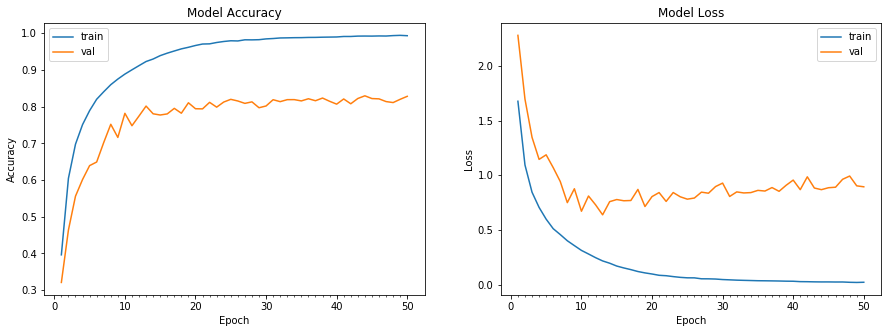

Accuracy on test data is: 82.80


In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels),callbacks=[LearningRateScheduler(scheduler)], verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))